In [1]:
import pandas as pd
import numpy as np
# import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

In [2]:
def readVisitCSV(fn):
    df = pd.read_csv(fn)
    df['Date'] = pd.to_datetime(df['Date'])
    return df

def logFitFn(x, a, b):
    return a*np.log(x)+b

def sqrtFitFn(x, a, b, c):
    return a*np.sqrt(x-b)+c

def polyFnOrd2(x, a, b, c):
    return a*x**2 + b*x + c

def polyFnOrd3(x, a, b, c, d):
    return a*x**3 + b*x**2 + c*x + d

def polyFnOrd4(x, a, b, c, d, f):
    return a*x**4 + b*x**3 + c*x**2 + d*x + f

def polyOrd6Fn(x, a, b, c, d, e, f, g):
    return np.polyval([a, b, c, d, e, f, g], x)

<AxesSubplot:title={'center':'COVID-19 Screening Visits 2020'}, xlabel='Date', ylabel='Visit Count'>

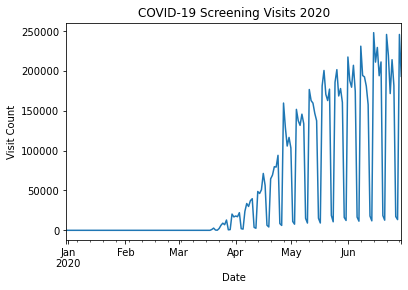

In [3]:
screenDf = readVisitCSV('screening_data.csv')
screenDf.plot(
    x='Date',
    y='Counts',
    legend=False,
    ylabel='Visit Count',
    title="COVID-19 Screening Visits 2020"
)



<AxesSubplot:title={'center':'Total Clinical Visits 2020'}, xlabel='Date', ylabel='Visit Count'>

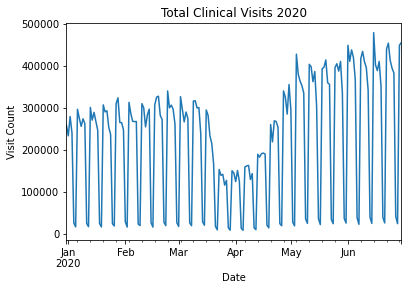

In [4]:
visitDf = readVisitCSV('visit_data.csv')
visitDf.plot(
    x='Date',
    y='Counts',
    legend=False,
    ylabel='Visit Count',
    title="Total Clinical Visits 2020"
)



<AxesSubplot:title={'center':'Rate of Screening Visits to Total Visits 2020'}, xlabel='Date', ylabel='Counts'>

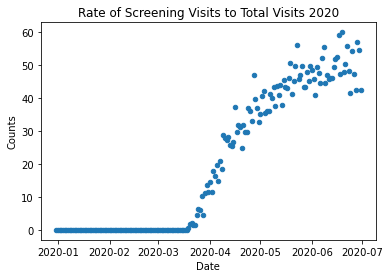

In [5]:
screenToVisitDf = screenDf.copy()
screenToVisitDf['Counts'] = screenDf['Counts']*100/visitDf['Counts']
screenToVisitDf.plot(
    x='Date',
    y='Counts',
    kind='scatter',
    legend=False,
    ylabel='% Screening Visits',
    title="Rate of Screening Visits to Total Visits 2020"
)

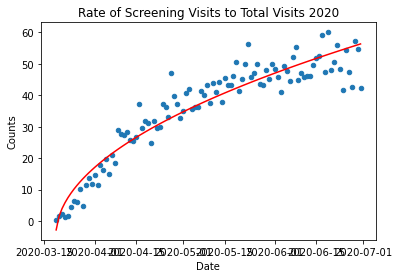

In [6]:
cleanedScreenRatioDf = screenToVisitDf[screenToVisitDf.Counts != 0]
xDate = cleanedScreenRatioDf['Date']
x = cleanedScreenRatioDf.index
y = cleanedScreenRatioDf['Counts']
popt, pcov = curve_fit(logFitFn, x, y)
perr = np.sqrt(np.diag(pcov))
yLogFit = logFitFn(x, *popt)

poly_popt, poly_pcov = curve_fit(polyFnOrd2, x, y)
yPolyFit = polyFnOrd2(x, *poly_popt)

hiDayIndex = np.ceil(x[0]/10)*10
loDayIndex = np.floor(x[0]/10)*10

sqrt_bounds = ([-np.inf, loDayIndex, -np.inf], [np.inf, hiDayIndex, np.inf])

sqrt_popt, sqrt_pcov = curve_fit(sqrtFitFn, x, y, bounds=sqrt_bounds)
ySqrtFit = sqrtFitFn(x, *sqrt_popt)

screeningPlot = cleanedScreenRatioDf.plot(
    x='Date',
    y='Counts',
    kind='scatter',
    legend=False,
    ylabel='% Screening Visits',
    title="Rate of Screening Visits to Total Visits 2020"
)
screeningPlot.plot(
    xDate,
    ySqrtFit,
    color='red'
)

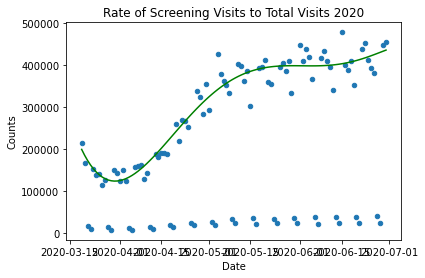

In [7]:
cleanedVisitDf = visitDf.loc[cleanedScreenRatioDf.index]
weekdayVisitDf = cleanedVisitDf.loc[cleanedVisitDf['Date'].dt.dayofweek.lt(5)]

x = weekdayVisitDf.index
y = weekdayVisitDf['Counts']
wkDay_popt, wkDay_pcov = curve_fit(polyFnOrd4, x, y)

poly, poly_cov = np.polyfit(x, y, 6, cov=True)
poly, poly_cov = curve_fit(polyOrd6Fn, x, y)
poly_perr = np.sqrt(np.diag(poly_cov))

yWkDayFit = np.polyval(poly, cleanedVisitDf.index)



visitPlot = cleanedVisitDf.plot(
    x='Date',
    y='Counts',
    kind='scatter',
    legend=False,
    ylabel='% Screening Visits',
    title="Rate of Screening Visits to Total Visits 2020"
)

visitPlot.plot(
    cleanedVisitDf['Date'],
    yWkDayFit,
    color='green'
)


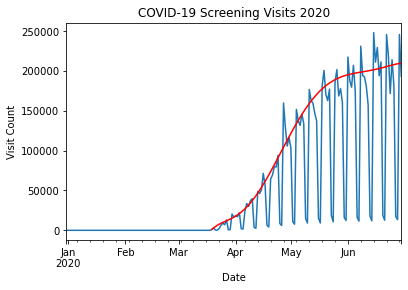

In [8]:
finalFit = yWkDayFit*yPolyFit/100

screenDf.plot(
    x='Date',
    y='Counts',
    legend=False,
    ylabel='Visit Count',
    title="COVID-19 Screening Visits 2020"
).plot(
    cleanedVisitDf['Date'],
    finalFit,
    color='red'
)


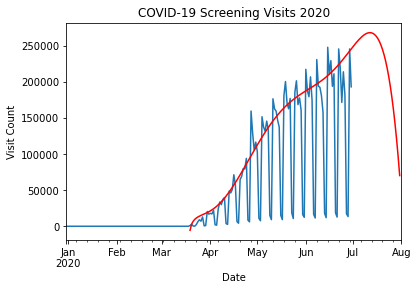

In [9]:

extendedDates = pd.date_range(start='2019-12-31', end='2020-07-31', freq='D')
testFit = screenDf.set_index('Date')
screenDf.head()


testFit = testFit.reindex(extendedDates).reset_index().rename(columns={'index':'Date'})
# scrStartDate = screenRateDf['Date'].iat[0].date()



testFit.head()

# yPolyFit = polyFnOrd2(testFit.index, *poly_popt)
yWkDayFit = np.polyval(poly, testFit.index)

ySqrtFit = sqrtFitFn(testFit.index, *sqrt_popt)

finalFit = yWkDayFit*ySqrtFit/100

testFit.plot(
    x='Date',
    y='Counts',
    xlim=['2019-12-31','2020-08-01'],
    legend=False,
    ylabel='Visit Count',
    title="COVID-19 Screening Visits 2020"
).plot(
    testFit['Date'],
    finalFit,
    color='red'
)


In [10]:

startDate = screenDf['Date'].iat[0].date()
endDate = (screenDf['Date'].iat[-1] + pd.to_timedelta('31D')).date()

print(startDate, endDate)

2019-12-31 2020-07-31


(True, nan)

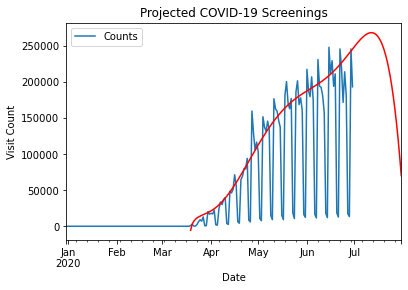

In [11]:
import problem

problem.main('visit_data.csv', 'screening_data.csv', 300000)

In [12]:
screenThresh = 300000
pd.Series(finalFit).gt(screenThresh).any()

True